# 0. Preparing the Library and Data

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("PySparkVisualization") \
.getOrCreate()

In [2]:
FILE_LOC = "housing.csv"
FILE_TYPE = "csv"
INFER_SCHEMA = "true"
HEADER = "true"
DELIM = ","

df = spark.read.format(FILE_TYPE)\
.option("inferSchema", INFER_SCHEMA)\
.option("header", HEADER)\
.option("sep", DELIM)\
.load(FILE_LOC)

In [3]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



# 1. Data Cleaning

In [4]:
df.describe().show(vertical = True)

-RECORD 0---------------------------------
 summary            | count               
 longitude          | 20640               
 latitude           | 20640               
 housing_median_age | 20640               
 total_rooms        | 20640               
 total_bedrooms     | 20433               
 population         | 20640               
 households         | 20640               
 median_income      | 20640               
 median_house_value | 20640               
 ocean_proximity    | 20640               
-RECORD 1---------------------------------
 summary            | mean                
 longitude          | -119.56970445736148 
 latitude           | 35.6318614341087    
 housing_median_age | 28.639486434108527  
 total_rooms        | 2635.7630813953488  
 total_bedrooms     | 537.8705525375618   
 population         | 1425.4767441860465  
 households         | 499.5396802325581   
 median_income      | 3.8706710029070246  
 median_house_value | 206855.81690891474  
 ocean_prox

In [5]:
df.createOrReplaceTempView('HousingData')

In [6]:
df_all = spark.sql(
"""
SELECT *
FROM HousingData
"""
).toPandas()

In [7]:
df_all.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
df_clean = df_all.dropna()

In [9]:
df_clean.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

<Axes: xlabel='median_income', ylabel='median_house_value'>

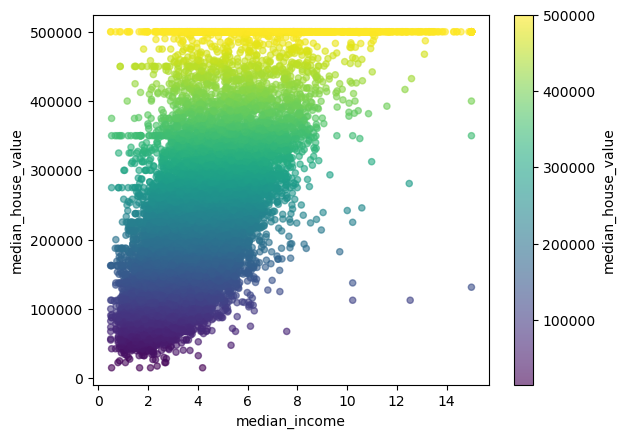

In [10]:
# There exists some weird outliers
df_clean.plot.scatter(x = 'median_income',
                      y = 'median_house_value',
                      alpha = .6,
                      c ='median_house_value',
                      colormap = 'viridis')

In [11]:
df_clean = df_clean[df_clean['median_house_value'] < 500000]

In [12]:
# Store as table if necessary
spark.createDataFrame(df_clean).createOrReplaceTempView("HousingDataClean") 

# 2. Data Visualization

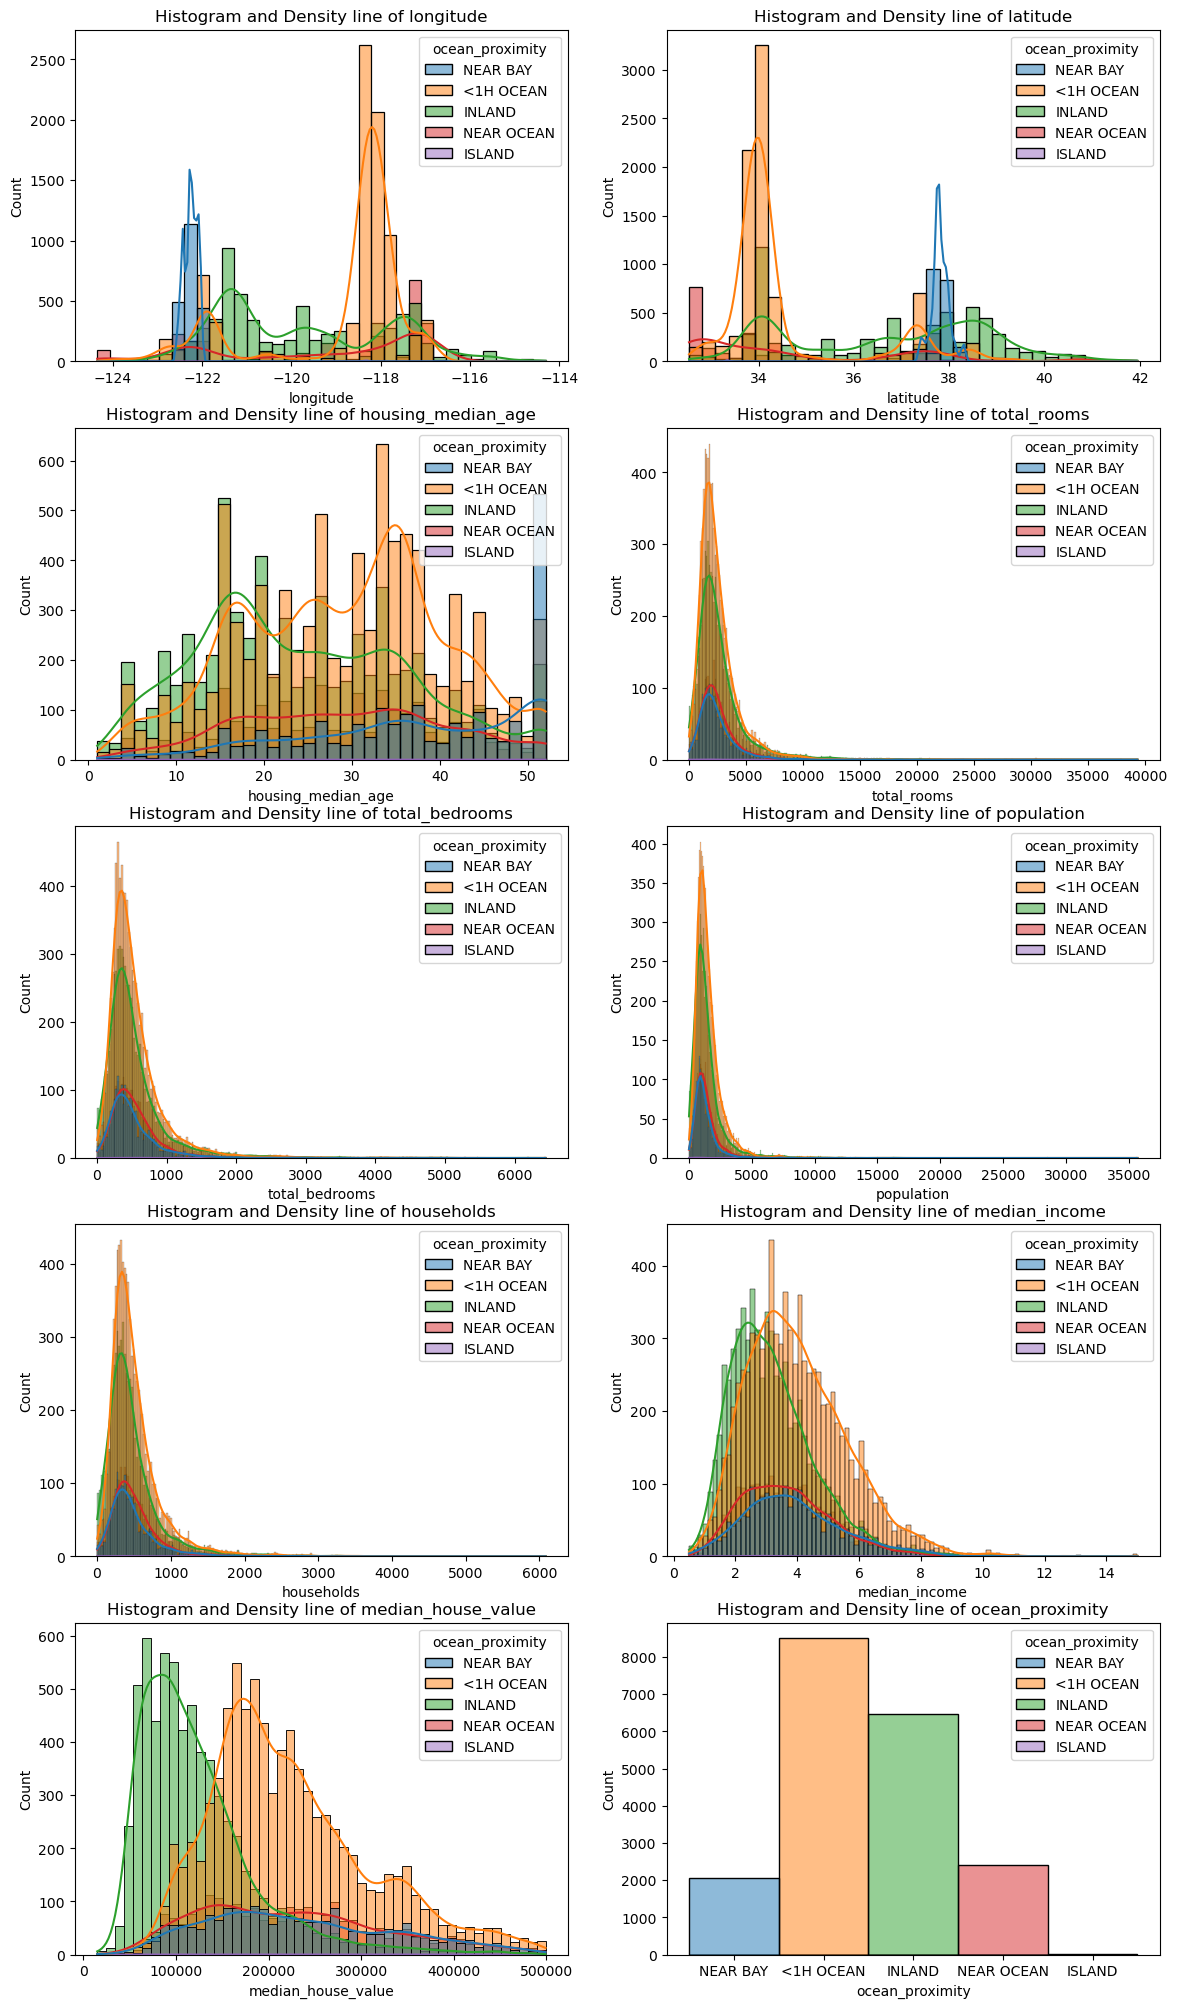

In [13]:
col = df_clean.columns
col_len = len(col)

fig, ax = plt.subplots(int((col_len + 1)/2),
                       2,
                       figsize = (14, 25))

ax = ax.flatten()

for i, cl in enumerate(col):
    sns.histplot(df_clean,
                x = cl,
                kde = True,
                ax = ax[i],
                hue = 'ocean_proximity')
    ax[i].set_title(f'Histogram and Density line of {cl}')

plt.show()

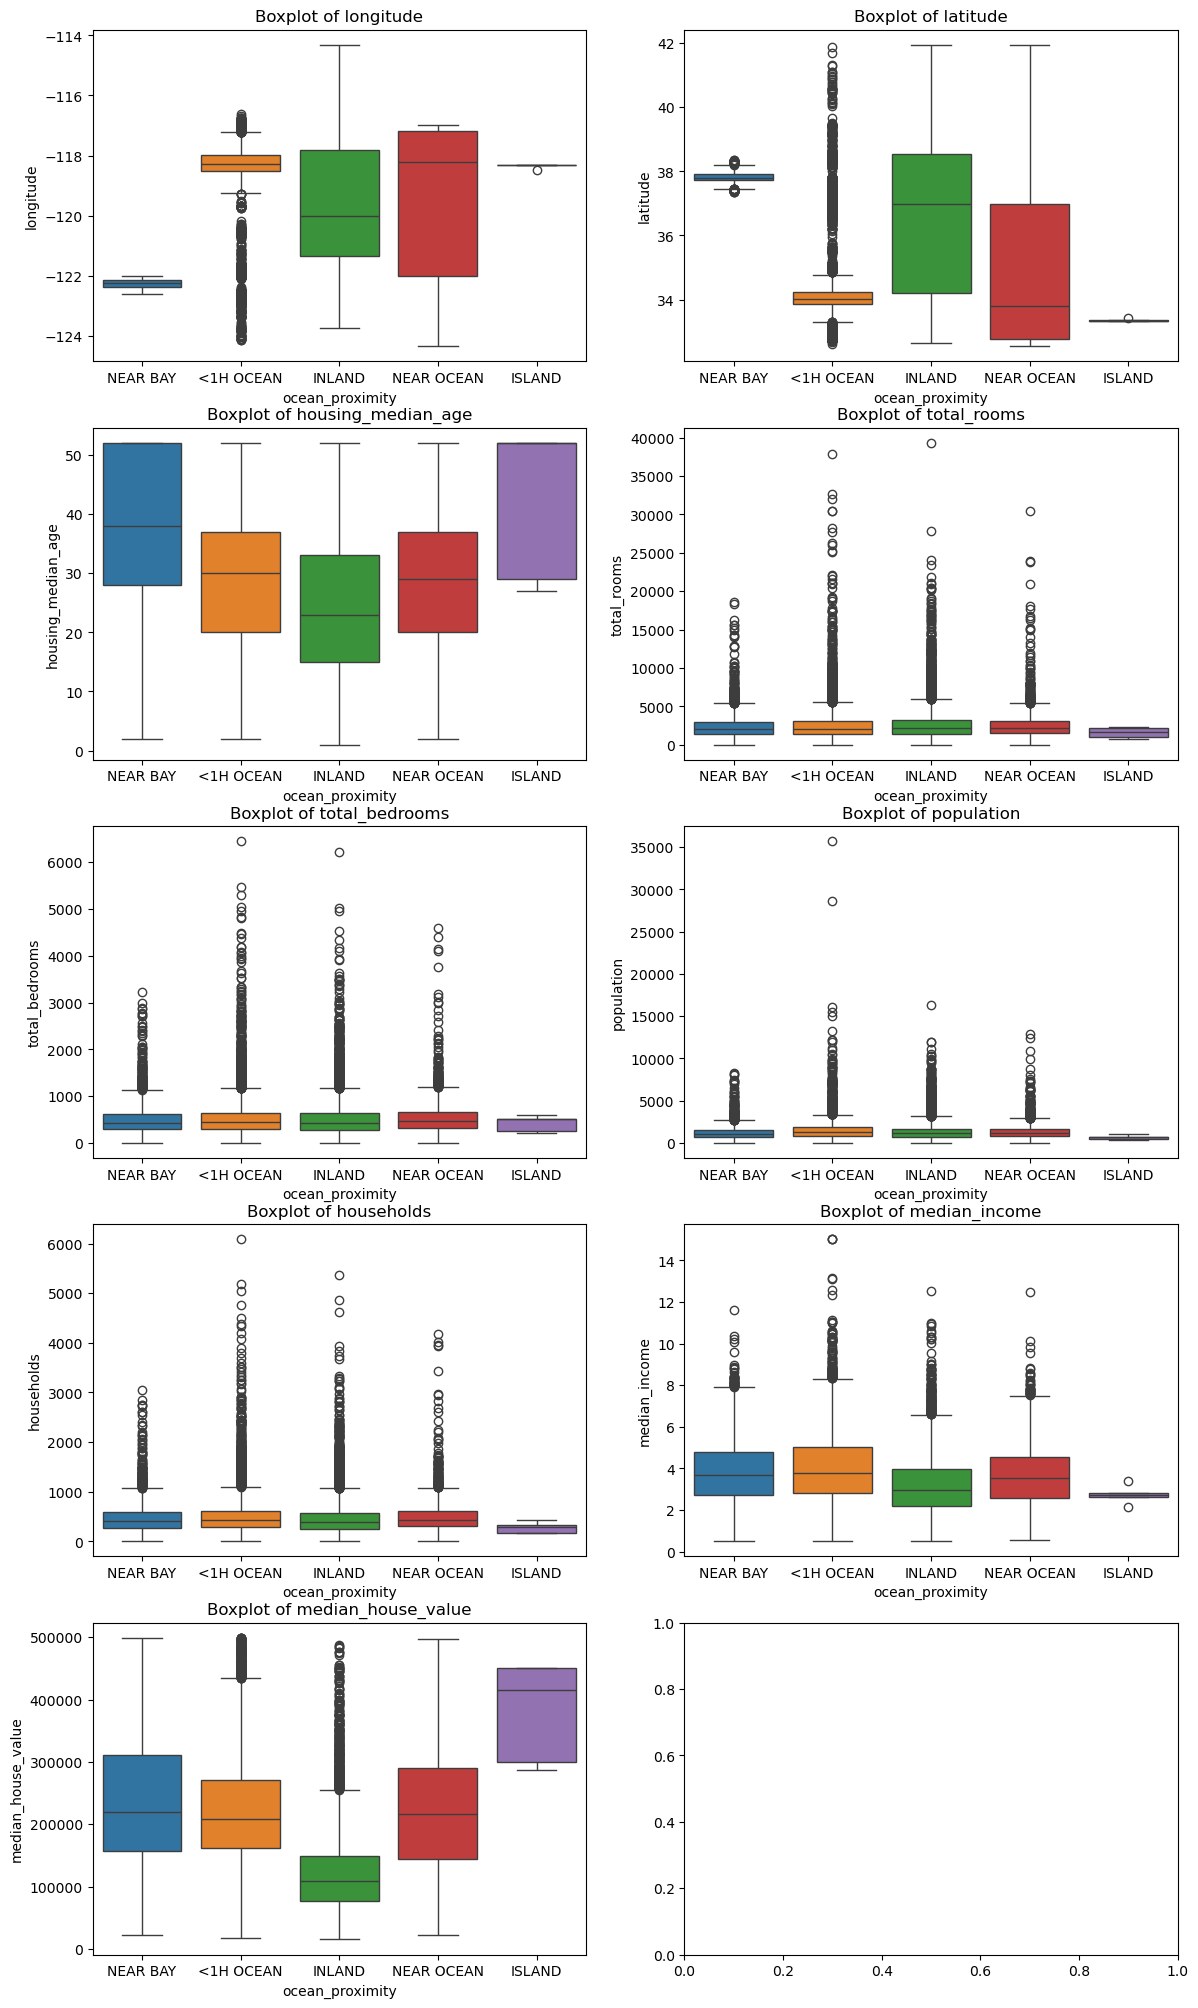

In [14]:
col = df_clean.columns
col_len = len(col)

fig, ax = plt.subplots(int((col_len + 1)/2),
                       2,
                       figsize = (14, 25))

ax = ax.flatten()

for i, cl in enumerate(col[:-1]):
  sns.boxplot(df_clean,
              x = 'ocean_proximity',
              y = cl,
              ax = ax[i],
              hue = 'ocean_proximity')
  ax[i].set_title(f'Boxplot of {cl}')

plt.show()

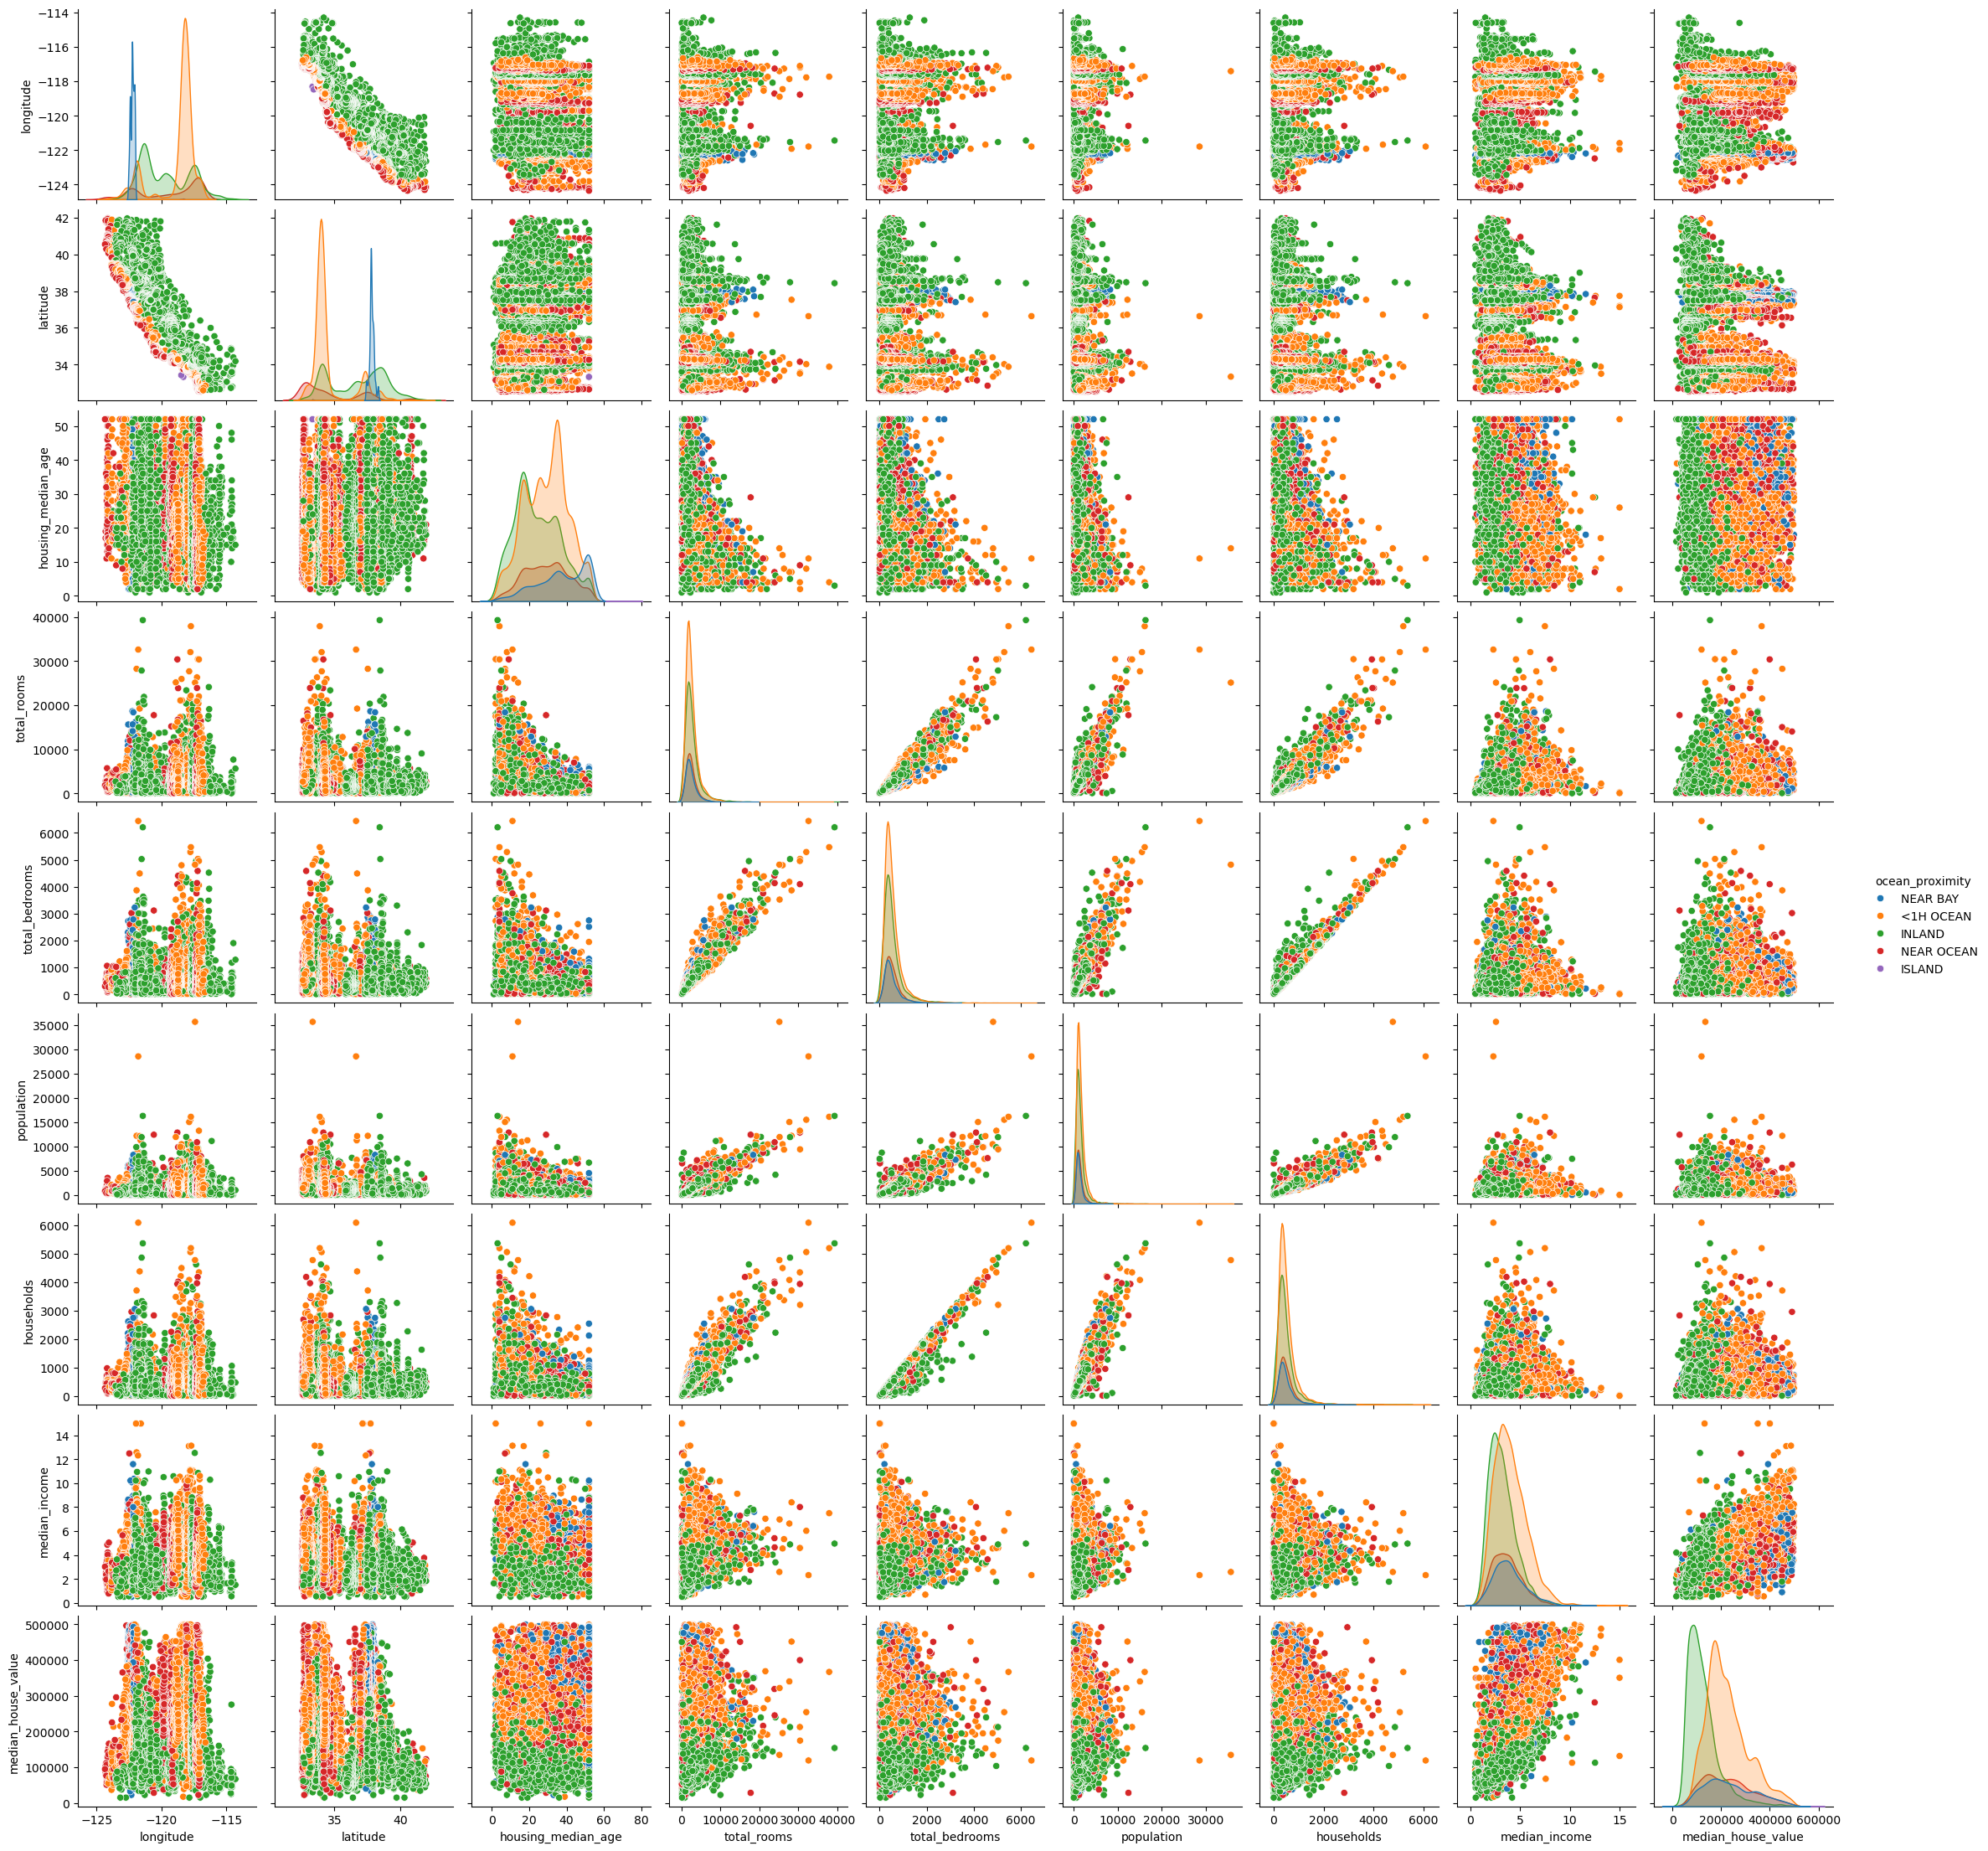

In [27]:
sns.pairplot(df_clean, hue = "ocean_proximity")

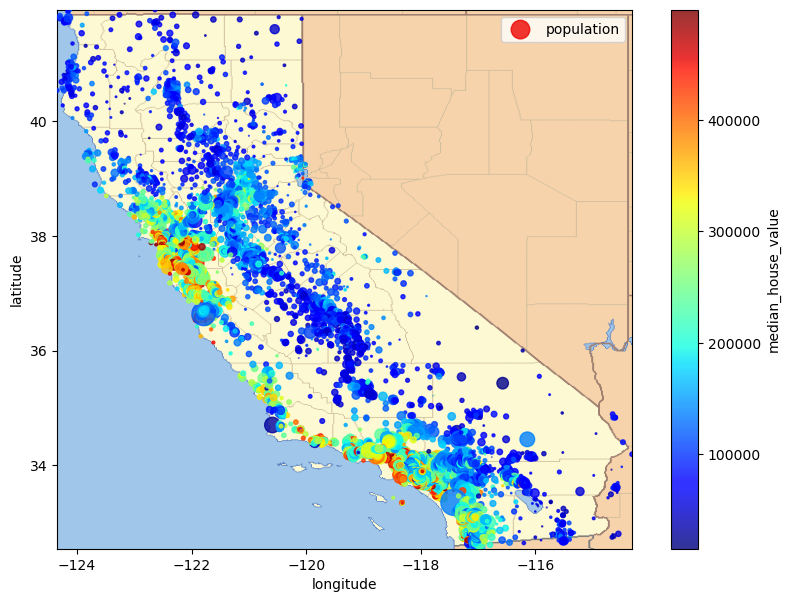

In [15]:
plt.figure(figsize=(10,7))
img=plt.imread('california.png')

plt.imshow(img, zorder=0, extent=[df_clean['longitude'].min(), df_clean['longitude'].max(), df_clean['latitude'].min(), df_clean['latitude'].max()])
ax = plt.gca()
df_clean.plot(x='longitude', y='latitude', kind='scatter', alpha=0.8, 
         s=df_clean['population']/100, label='population', ax=ax,
         c='median_house_value', cmap='jet', colorbar=True, 
         zorder=5)
plt.legend()
plt.show()

<Axes: >

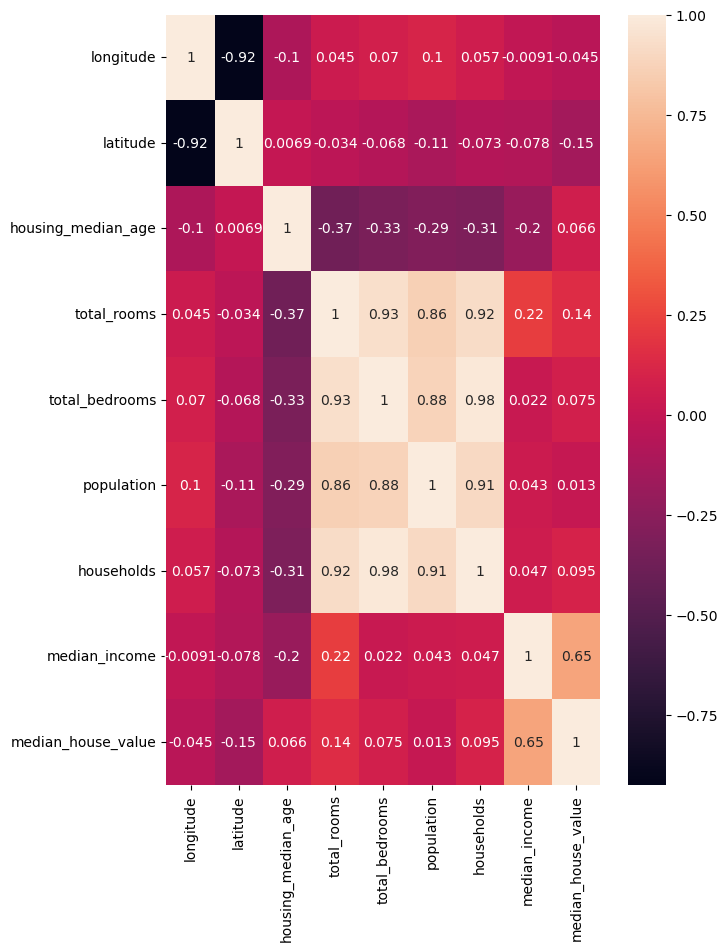

In [26]:
df_corr = df_clean.corr(numeric_only = True)
plt.figure(figsize = (7, 10))
sns.heatmap(df_corr, annot = True)

<Axes: xlabel='ocean_proximity', ylabel='aggregate_value'>

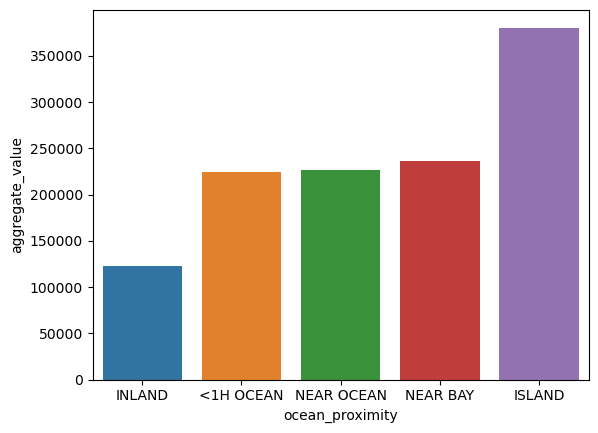

In [17]:
df_proximity_value = spark.sql(
"""
SELECT
    AVG(median_house_value) AS aggregate_value,
    ocean_proximity
FROM HousingDataClean
GROUP BY ocean_proximity
ORDER BY aggregate_value
"""
).toPandas()

sns.barplot(df_proximity_value, hue = "ocean_proximity", x = "ocean_proximity", y = "aggregate_value")

# 3. Regression

In [18]:
# Initializing the data            
x = spark.sql(
'''
    SELECT
        *
    FROM HousingDataClean
'''
)

In [19]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

labelIndexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed").fit(x)
x = x.drop("ocean_proximity")
x = x.withColumnRenamed("ocean_proximity_indexed", "ocean_proximity")
x.columns
assembler = VectorAssembler(inputCols=x.columns, outputCol="features")
lr = LinearRegression(maxIter=100, regParam=0.1, elasticNetParam=0.6, labelCol = "median_house_value")

In [20]:
pipeline = Pipeline(stages=[assembler, lr])

In [22]:
# Fit the model
lrModel = pipeline.fit(x)

# Print the coefficients and intercept for linear regression
print(f"Coefficients: {str(lrModel.stages[-1].coefficients)}")
print(f"Intercept: {str(lrModel.stages[-1].intercept)}")

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.stages[-1].summary
print(f"RMSE: {trainingSummary.rootMeanSquaredError}")
print(f"R^2: {trainingSummary.r2}")

Coefficients: [-7.136038932045484,-2.3026855870979626,0.3530952872388207,-0.11699663435569954,0.9993929303771536,0.01452139120310852,-0.5610606346416384,48.43596002364828,0.9997143901118198]
Intercept: -876.7930348451525
RMSE: 83.99664536745614
R^2: 0.9999992515762545
